In [1]:
import cv2
import json
import math
import csv  
import numpy as np
import mediapipe as mp
from matplotlib import pyplot as plt

# Initializing model 

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# Create useful functions

In [3]:
def get_predicted_hand_landmarks(results, image, includes_z=False):
    """
    Get hand landmark from image space
    """
    coordinates = []
    image_height, image_width, _ = image.shape
    for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
        for i in range(len(mp_hands.HandLandmark)):
            coordinate = [hand_landmarks.landmark[mp_hands.HandLandmark(i).value].x * image_width,
                          hand_landmarks.landmark[mp_hands.HandLandmark(i).value].y * image_height]
            if includes_z:
                coordinate.append(hand_landmarks.landmark[mp_hands.HandLandmark(i).value].z)

            coordinates.append(coordinate)
    return coordinates


def draw_predicted_hand_landmarks(results, image):
    """
    Draw hand landmarks on the image.
    """
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS)
    return image


def get_bbox_coordinates_mediapipe(results, image):
    """
    Get bounding box coordinates for a predicted hand landmark.
    """
    all_x, all_y = [], []
    image_height, image_width, _ = image.shape
    for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
        for i in mp_hands.HandLandmark:
            all_x.append(int(hand_landmarks.landmark[i].x * image_width))
            all_y.append(int(hand_landmarks.landmark[i].y * image_height))
    return min(all_x), min(all_y), max(all_x), max(all_y)


def get_bbox_coordinates(coordinates):
    """
    Get bounding box coordinates for a actual hand landmark.
    """
    all_x, all_y = [], []
    for coordinate in coordinates:
        all_x.append(coordinate[0])
        all_y.append(coordinate[1])
    return min(all_x), min(all_y), max(all_x), max(all_y)


def draw_bbox(results, image, extend, colour, is_predicted, coordinates=None):
    if is_predicted:
        x_min, y_min, x_max, y_max = get_bbox_coordinates_mediapipe(results, image)
    else:
        x_min, y_min, x_max, y_max = get_bbox_coordinates(coordinates)
    cv2.rectangle(image, (x_min - extend, y_min - extend), (x_max + extend, y_max + extend), colour, 1)
    return image


def projectPoints(xyz, K):
    """ Project 3D coordinates provided by the hands dataset into image space. """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]


def display_world_landmarks(results):
    for hand_world_landmarks in results.multi_hand_world_landmarks:
        mp_drawing.plot_landmarks(
            hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)


def get_image_index(image_path):
    filename = get_filename(image_path)
    index = int(filename.split('.')[0])
    return index


def get_filename(image_path):
    filename = image_path.split('/')[-1]
    return filename


def compute_euclidean_distances(pred_coordinates, actu_coordinates):
    variances = []
    for i in range(len(actu_coordinates)):
        variance = compute_single_euclidean_distances(pred_coordinates[i], actu_coordinates[i])
        variances.append(variance)
    return variances


def compute_single_euclidean_distances(pred_coordinate, actu_coordinate):
    variance = math.sqrt(pow(pred_coordinate[0] - actu_coordinate[0], 2) +
                         pow(pred_coordinate[1] - actu_coordinate[1], 2))
    return variance


def compute_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


def format_csv_result():
    header = ['filename', 'iou', 'mean_keypoint_error']
    for i in range(21):
        header.append("keypoint_error_" + str(i))
    return header


def tabulate_csv_result(filename, iou, coordinates_variances):
    coordinates_mean_error = sum(coordinates_variances) / len(coordinates_variances)
    data = [filename, iou, coordinates_mean_error]
    for each in coordinates_variances:
        data.append(each)
    return data


def write_csv_data(file_path, new_data, mode):
    with open(file_path, mode) as file:
        writer = csv.writer(file)
        writer.writerow(new_data)


def read_json_data(file_path):
    with open(file_path) as file:
        content = json.load(file)
    return content


def write_json_data(file_path, new_data, mode, key=None):
    if mode == 'w':
        with open(file_path, 'w') as file:
            json.dump(new_data, file)
    else:
        with open(file_path, 'r+') as file:
            content = json.load(file)
            content[key].append(new_data)
            file.seek(0)
            json.dump(content, file, indent=4)


def write_txt_file(file_path, new_data, mode):
    with open(file_path, mode) as file:
        file.write(new_data)

# Read files 

In [5]:
dataset_dir = '/Users/muxin/PyCharm/FreiHAND/'
with open(f'{dataset_dir}/training_xyz.json') as xyz_fp, open(f'{dataset_dir}/training_K.json') as K_fp:
    actu_xyz_array = json.load(xyz_fp)
    K_array = json.load(K_fp)

# Perform hands landmarks detection

In [4]:
mp_model =  mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [44]:
dataset_dir = r'/Users/muxin/PyCharm/CMUhand'
index = 13326
image_path = f'{dataset_dir}/original/hands_with_objects/{index:08d}.jpg'#/00000001.jpg'
ori_image_path = f'{dataset_dir}/original/ori_hands_with_objects/{index:08d}.jpg'
filename = f'{index:08d}.jpg'

image = cv2.imread(image_path) #cv2.flip(cv2.imread(file), 1)
ori_image = cv2.imread(ori_image_path)
ori_size = ori_image.shape[:-1]

feed_size = (244, 244)
image = cv2.resize(image, feed_size, interpolation = cv2.INTER_AREA)
feed_size = image.shape[:-1]

print('feed_size: ' + str(feed_size))
print('ori_size: ' + str(ori_size))

feed_size: (244, 244)
ori_size: (193, 193)


# HandDB

In [169]:
baseline_dir = r'/Users/muxin/PyCharm/HandDB/xyz'
baseline = read_json_data(baseline_dir + f'/{filename[:-4]}.json')
actual_coordinates = [[coordinate[i] for i in range(2)] for coordinate in baseline['hand_pts']]

# CMUhand

In [45]:
# Original ground truth cooridnates 
dataset_dir = r'/Users/muxin/PyCharm/CMUhand'
actual_coordinate_array = read_json_data(f'{dataset_dir}/labels.json')
print(filename)
actual_coordinates_ori = actual_coordinate_array[filename]
actual_coordinates_unify = [[point[0] / ori_size[0] * feed_size[0], point[1] / ori_size[1] * feed_size[1]] for point in
                            actual_coordinates_ori]
actual_coordinates_ori

00013326.jpg


[[52.57139999999981, 83.92789999999991],
 [63.59739999999988, 91.67689999999993],
 [89.33239999999978, 101.93589999999995],
 [109.07239999999979, 106.4819],
 [122.70739999999978, 113.26289999999995],
 [108.80439999999976, 79.5148999999999],
 [133.8893999999998, 89.59789999999998],
 [140.09039999999982, 102.72189999999989],
 [140.19039999999973, 111.66789999999992],
 [108.81939999999986, 77.45089999999993],
 [127.46739999999977, 98.9088999999999],
 [118.87839999999983, 112.07489999999996],
 [108.76139999999987, 115.31089999999995],
 [105.13039999999978, 79.15289999999993],
 [117.17639999999983, 101.45089999999993],
 [107.52239999999983, 112.12289999999996],
 [97.97839999999974, 114.00289999999995],
 [99.68939999999975, 82.86489999999992],
 [106.08939999999984, 102.45189999999991],
 [98.28239999999983, 110.30089999999996],
 [89.91739999999982, 112.62689999999998]]

In [52]:
# Adjust ground truth cooridnates 
dataset_dir = r'/Users/muxin/PyCharm/CMUhand/xyz'
actual_coordinates = read_json_data(dataset_dir + f'/{filename[:-4]}.json')['hand_pts']
print(actual_coordinates_unify == actual_coordinates)
actual_coordinates

True


[[66.46332435233137, 106.10573886010351],
 [80.40293056994803, 115.90240207253876],
 [112.93837098445567, 128.87232953367868],
 [137.8946404145075, 134.6196041450777],
 [155.1326715025904, 143.1924746113989],
 [137.55582176165774, 100.52660932642475],
 [169.26950051813446, 113.27402901554402],
 [177.10910673575108, 129.86602901554392],
 [177.23553160621728, 141.17599792746103],
 [137.5747854922278, 97.91719999999992],
 [161.15049533678726, 125.0454487046631],
 [150.29186321243503, 141.69054715025902],
 [137.50145906735736, 145.78165595854915],
 [132.9109720207251, 100.0689512953367],
 [148.14011191709824, 128.25916891191702],
 [135.9350549222796, 141.75123108808285],
 [123.86906528497377, 144.12801865284968],
 [126.03219481865254, 104.76184248704654],
 [134.1233865284972, 129.52468186528486],
 [124.25339689119147, 139.44776994818648],
 [113.6779564766837, 142.38841243523314]]

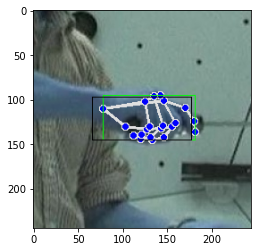

In [47]:
# Convert the BGR image to RGB before processing.
results = mp_model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
pred_coordinates = []
if  results.multi_hand_landmarks:    
    pred_coordinates = get_predicted_hand_landmarks(results, image.copy(), True)
    annotated_image = draw_predicted_hand_landmarks(results, image.copy())
    annotated_image = draw_bbox(results, annotated_image.copy(), 0, (0, 255, 0), True)
    
    actual_coordinates_int = [[int(coordinate[i]) for i in range(2)] for coordinate in actual_coordinates]
    annotated_image = draw_bbox(results, annotated_image.copy(), 0, (0, 0, 0), False, actual_coordinates_int)

    plt.imshow(annotated_image)
    plt.show() 

In [48]:
ori_size

(193, 193)

In [49]:
feed_size 

(244, 244)

In [50]:
 # Project predicted 3D coordinates into 2D image space
predicted_coordinates = get_predicted_hand_landmarks(results, image)

# Compute the area of both the prediction and ground-truth rectangles
predicted_bbox = get_bbox_coordinates(predicted_coordinates)
actual_bbox = get_bbox_coordinates(actual_coordinates)

# compute intersection over union between the prediction and ground-truth rectangles
iou = compute_intersection_over_union(predicted_bbox, actual_bbox)
# Compute euclidean distances between the prediction and ground-truth hand landmarks
coordinates_variances = compute_euclidean_distances(predicted_coordinates, actual_coordinates)
iou

0.8129305608111462

In [22]:
predicted_bbox

(72.13977932929993, 62.83926248550415, 124.97547602653503, 151.77786993980408)

In [23]:
actual_bbox

(33.27839999999992, 37.73239999999987, 88.74239999999986, 84.28839999999991)

In [26]:
predicted_coordinates

[[82.85553467273712, 151.77786993980408],
 [104.71322906017303, 128.1452100276947],
 [115.09214162826538, 105.07864987850189],
 [119.79414594173431, 88.77236759662628],
 [123.62845396995544, 80.14028608798981],
 [93.03432822227478, 87.23803210258484],
 [92.44672584533691, 62.83926248550415],
 [110.46643996238708, 69.22750949859619],
 [124.97547602653503, 81.18419909477234],
 [82.3784122467041, 101.07152104377747],
 [80.44282793998718, 81.79302775859833],
 [103.3404940366745, 91.38441526889801],
 [118.68922281265259, 103.05795681476593],
 [75.33337926864624, 120.17770254611969],
 [73.83664608001709, 109.9443998336792],
 [96.76087594032288, 116.57236790657043],
 [113.20681250095367, 123.34786558151245],
 [72.13977932929993, 142.1520869731903],
 [72.41750264167786, 142.85707020759583],
 [88.44902849197388, 145.8387999534607],
 [101.58729290962219, 148.76286458969116]]

In [27]:
actual_coordinates

[[94.54479999999967, 168.57679999999982],
 [124.9348, 147.6107999999997],
 [156.3547999999996, 122.92479999999978],
 [173.5087999999996, 123.67479999999978],
 [177.48479999999972, 134.0447999999999],
 [101.26279999999997, 93.11279999999988],
 [97.58479999999963, 75.46479999999974],
 [112.46879999999965, 80.61479999999983],
 [126.96879999999965, 90.23879999999986],
 [81.83679999999958, 107.21879999999987],
 [79.04479999999967, 91.9667999999997],
 [100.40679999999975, 101.92679999999973],
 [120.8747999999996, 111.83479999999986],
 [71.5627999999997, 125.62879999999971],
 [70.9387999999999, 116.6927999999998],
 [94.01279999999997, 124.53879999999981],
 [114.80279999999993, 133.08079999999973],
 [66.55679999999984, 146.71479999999974],
 [74.0627999999997, 144.3907999999999],
 [89.60279999999966, 148.98879999999986],
 [105.56479999999965, 153.80079999999975]]

In [51]:
coordinates_variances

[13.346708118992069,
 27.87447032910576,
 15.107812913558007,
 6.299065665154766,
 12.757303578525566,
 9.144951270128196,
 4.337821362839712,
 6.497563940711447,
 6.3262892301392055,
 5.584677848304909,
 2.2942947878122726,
 3.999746489588367,
 3.589216378688859,
 4.196187464089026,
 2.659441758967011,
 4.04291385147976,
 3.663481717823279,
 2.5698195428217967,
 3.468254554667938,
 3.21008299080926,
 2.35250170695837]

In [58]:
sum([37.795/feed_size[0]* ori_size[0], 37.795/feed_size[1]* ori_size[1]])/2

36.78816598360656

In [41]:
dataset = 'HandDB'
hand_localisation_threshold = [-1, 37.795] if dataset == 'FreiHand' else [-1, 57.002]
hand_localisation_threshold

[-1, 57.002]